In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from sklearn import svm

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('D:\Analytics_vidya_/train_2kmZucJ.csv')
df.shape

(7920, 3)

In [4]:
df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
df.label.value_counts()

0    5894
1    2026
Name: label, dtype: int64

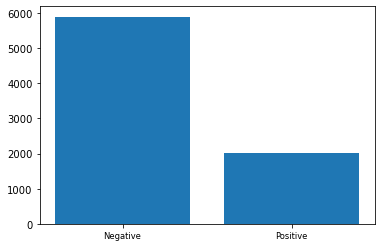

In [6]:
import matplotlib.pyplot as plt
# emulate your ex3.Severity.value_counts()
data11 = {'Negative': 5894, 'Positive': 2026}
df11 = pd.Series(data11)

plt.bar(range(len(df11)), df11.values, align='center')
plt.xticks(range(len(df11)), df11.index.values, size='small')
plt.show()

In [7]:
df.tweet.isnull().value_counts()

False    7920
Name: tweet, dtype: int64

In [8]:
df.shape

(7920, 3)

In [9]:
messages = df.tweet.tolist()

In [10]:
#Data cleaning and preprocessing
import re
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(0, len(messages)):
    message = re.sub('[^a-zA-Z]', ' ', str(messages[i]))
    message = message.lower()
    message = message.split()
    
    message = [lemmatizer.lemmatize(word) for word in message if not word in stopwords.words('english')]
    message = ' '.join(message)
    corpus.append(message)

In [11]:
# Creating the TF-IDF model
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(corpus)
X = vectorizer.transform(corpus).toarray()

In [12]:
X.shape

(7920, 21616)

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_P = pca.fit_transform(X)

In [14]:
X_P.shape

(7920, 5490)

In [15]:
y = df['label'].replace(0, -1)

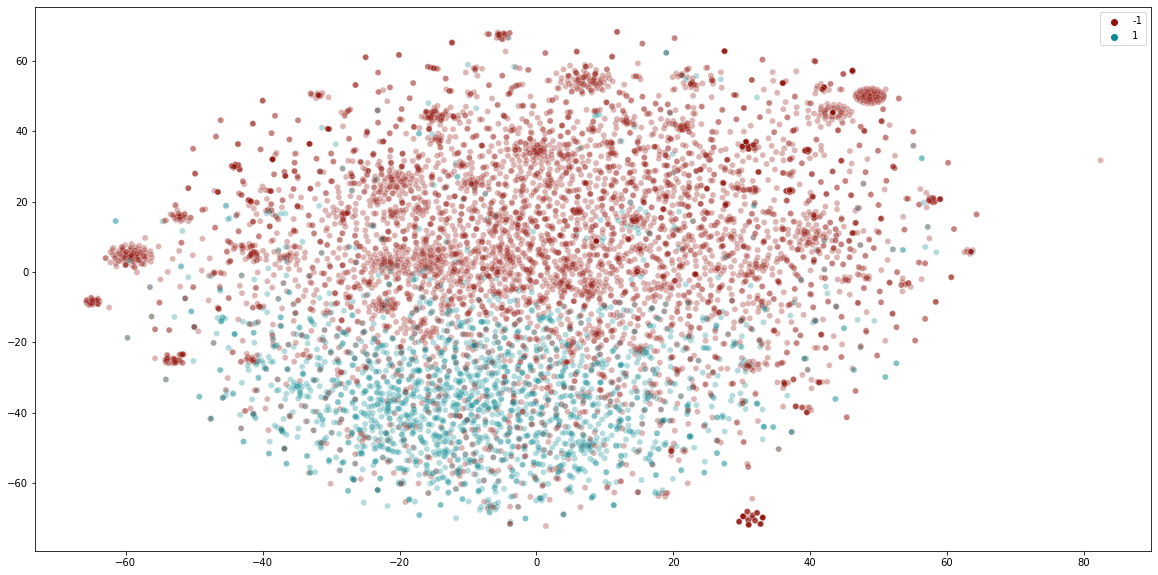

In [16]:
from sklearn.manifold import TSNE
import seaborn as sns
labels = y.to_list()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(X_P)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(2, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [17]:
# Train Test Split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_P,y, test_size = 0.20, random_state = 0)

In [18]:
X_train.shape

(6336, 5490)

In [19]:
from collections import Counter
print("Before SMOTE :" , Counter(y_train))

Before SMOTE : Counter({-1: 4716, 1: 1620})


In [20]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

In [21]:

print("After SMOTE :" , Counter(y_train))

After SMOTE : Counter({-1: 4716, 1: 4716})


In [33]:
k_value = np.array(X_train @ X_train.T + np.identity(len(y_train))*1e-12)

In [34]:
k_value

array([[ 0.90569582,  0.03024735, -0.00576371, ..., -0.01031847,
        -0.00160369, -0.00467833],
       [ 0.03024735,  0.93353034, -0.00816754, ..., -0.00103403,
         0.00184671,  0.01013827],
       [-0.00576371, -0.00816754,  0.86057435, ...,  0.0077897 ,
        -0.00119457, -0.01020808],
       ...,
       [-0.01031847, -0.00103403,  0.0077897 , ...,  0.56932396,
         0.23335947, -0.00380725],
       [-0.00160369,  0.00184671, -0.00119457, ...,  0.23335947,
         0.65951877,  0.00265902],
       [-0.00467833,  0.01013827, -0.01020808, ..., -0.00380725,
         0.00265902,  0.84791026]])

In [35]:
#  check PSD
np.linalg.cholesky(k_value)

array([[ 9.51680526e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.17830963e-02,  9.65670843e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.05634560e-03, -8.25856350e-03,  9.27614933e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.08423631e-02, -7.13936157e-04,  8.32040819e-03, ...,
         1.13294286e-06,  0.00000000e+00,  0.00000000e+00],
       [-1.68511624e-03,  1.96782029e-03, -1.28126618e-03, ...,
         7.73597901e-08,  1.08097590e-06,  0.00000000e+00],
       [-4.91586406e-03,  1.06604774e-02, -1.09418335e-02, ...,
        -4.22465555e-12,  3.88534126e-12,  1.08689101e-06]])

In [36]:
alpha = cp.Variable(shape=y_train.shape)       # Create optimization variables.

beta = cp.multiply(alpha, y_train) # to simplify notation

K = cp.Parameter(shape=k_value.shape, PSD=True, value=k_value)

# objective function
obj = .5 * cp.quad_form(beta, K) - np.ones(alpha.shape).T @ alpha

# constraints
const = [np.array(y_train.T) @ alpha == 0,
        -alpha <= np.zeros(alpha.shape),
        alpha <= 10*np.ones(shape=alpha.shape)]
prob = cp.Problem(cp.Minimize(obj), const)

In [37]:
result = prob.solve()

In [38]:
w = np.multiply(y_train, alpha.value).T @ X_train

In [39]:
S = (alpha.value > 1e-4).flatten()
b = y_train[S] - X_train[S] @ w
# b = b[0]
b = np.mean(b)                          # Computing Bias term.

In [40]:
def classify(x):
    result = w @ x + b
    return np.sign(result)

In [41]:
correct = 0
incorrect = 0
predictions = []
for i in X_test:
    
    my_svm = classify(i)
    
    predictions.append(my_svm)
    
predictions = np.array(predictions)

In [42]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.90      0.90      0.90      1178
           1       0.71      0.69      0.70       406

    accuracy                           0.85      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.85      0.85      0.85      1584



In [43]:
sklearn_svm = svm.SVC(C = 10, kernel='linear')
sklearn_svm.fit(X_train, y_train)

SVC(C=10, kernel='linear')

In [44]:
prediction = sklearn_svm.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

          -1       0.90      0.90      0.90      1178
           1       0.71      0.70      0.70       406

    accuracy                           0.85      1584
   macro avg       0.80      0.80      0.80      1584
weighted avg       0.85      0.85      0.85      1584



In [46]:
def gaussian_kernel(x, y, gamma=0.5):
        return np.exp(-gamma*linalg.norm(x - y) ** 2 )

In [47]:
from numpy import linalg
n_samples, n_features = X_train.shape
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        K[i, j] = gaussian_kernel(X_train[i], X_train[j], gamma=0.5)   # Kernel trick.

In [48]:

K

array([[1.        , 0.4109163 , 0.41110822, ..., 0.47339348, 0.45647973,
        0.41416892],
       [0.4109163 , 1.        , 0.40445294, ..., 0.4712054 , 0.45172674,
        0.41454157],
       [0.41110822, 0.40445294, 1.        , ..., 0.49304272, 0.46708635,
        0.42128303],
       ...,
       [0.47339348, 0.4712054 , 0.49304272, ..., 1.        , 0.68313561,
        0.49045372],
       [0.45647973, 0.45172674, 0.46708635, ..., 0.68313561, 1.        ,
        0.47186824],
       [0.41416892, 0.41454157, 0.42128303, ..., 0.49045372, 0.47186824,
        1.        ]])

In [49]:
K_new = K+np.identity(len(y_train))*1e-12

In [50]:
K_new

array([[1.        , 0.4109163 , 0.41110822, ..., 0.47339348, 0.45647973,
        0.41416892],
       [0.4109163 , 1.        , 0.40445294, ..., 0.4712054 , 0.45172674,
        0.41454157],
       [0.41110822, 0.40445294, 1.        , ..., 0.49304272, 0.46708635,
        0.42128303],
       ...,
       [0.47339348, 0.4712054 , 0.49304272, ..., 1.        , 0.68313561,
        0.49045372],
       [0.45647973, 0.45172674, 0.46708635, ..., 0.68313561, 1.        ,
        0.47186824],
       [0.41416892, 0.41454157, 0.42128303, ..., 0.49045372, 0.47186824,
        1.        ]])

In [51]:
#  check PSD
np.linalg.cholesky(K_new)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.10916302e-01,  9.11673073e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.11108219e-01,  2.58340274e-01,  8.74214124e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.73393479e-01,  3.03486318e-01,  2.51682082e-01, ...,
         2.13437971e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.56479727e-01,  2.89743969e-01,  2.34005885e-01, ...,
         1.71608330e-02,  1.70830535e-01,  0.00000000e+00],
       [ 4.14168917e-01,  2.68026788e-01,  2.07926947e-01, ...,
        -2.42276857e-06, -1.76465369e-06,  1.06372692e-02]])

In [ ]:
alpha = cp.Variable(shape=y_train.shape)

beta = cp.multiply(alpha, y_train) # to simplify notation

K = cp.Parameter(shape=K_new.shape, PSD=True, value=K_new)

# objective function
obj = .5 * cp.quad_form(beta, K) - np.ones(alpha.shape).T @ alpha

# constraints
const = [np.array(y_train.T) @ alpha == 0,
        -alpha <= np.zeros(alpha.shape),
        alpha <= 10*np.ones(shape=alpha.shape)]
prob = cp.Problem(cp.Minimize(obj), const)

In [47]:
result = prob.solve()

In [48]:
w = np.multiply(y_train, alpha.value).T @ X_train

In [49]:
S = (alpha.value > 1e-4).flatten()
b = y_train[S] - X_train[S] @ w
b = b[0]
# b = np.mean(b)

In [50]:
def classify(x):
    result = w @ x + b
    return np.sign(result)

In [51]:
correct = 0
incorrect = 0
predictions = []
for i in X_test:
    
    my_svm = classify(i)
    
    predictions.append(my_svm)
    
predictions = np.array(predictions)

In [52]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.84      0.96      0.90      1178
           1       0.79      0.49      0.60       406

    accuracy                           0.83      1584
   macro avg       0.82      0.72      0.75      1584
weighted avg       0.83      0.83      0.82      1584



In [53]:
sklearn_svm = svm.SVC(kernel='rbf')
sklearn_svm.fit(X_train, y_train)

SVC()

In [54]:
prediction = sklearn_svm.predict(X_test)

In [55]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

          -1       0.91      0.92      0.92      1178
           1       0.77      0.73      0.75       406

    accuracy                           0.87      1584
   macro avg       0.84      0.83      0.83      1584
weighted avg       0.87      0.87      0.87      1584

